In [1]:
import os
import tensorflow as tf
from tensorflow.keras import layers 
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import img_to_array
monet_images=[]
photos=[]
for i in os.listdir('/kaggle/input/gan-getting-started/monet_jpg'):
    monet_images.append(os.path.join('/kaggle/input/gan-getting-started/monet_jpg',i))
for i in os.listdir('/kaggle/input/gan-getting-started/photo_jpg'):
    photos.append(os.path.join('/kaggle/input/gan-getting-started/photo_jpg',i))
def imgtoarr(path):
    img=load_img(path,target_size=(299,299))
    i=img_to_array(img).astype('float32')
    i=i/255
    i = i.reshape((1, i.shape[0], i.shape[1], i.shape[2]))
    return i
monet_arr=map(imgtoarr,monet_images)
photos_arr=map(imgtoarr,photos)
def generator_model():
    model =tf.keras.Sequential()
    model.add(layers.Dense(7*7*256,input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    model.add(layers.Reshape((7,7,256)))
    
    model.add(layers.UpSampling2D())
    model.add(layers.Conv2D(128,5,padding='same',strides=(1,1)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.UpSampling2D())
    model.add(layers.Conv2D(128,5,padding='same',strides=(2,2)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2D(128,4,padding='same',strides=(2,2)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2D(128,4,padding='same',strides=(1,1)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())
    
    model.add(layers.Conv2D(1,4,padding='same',activation='sigmoid'))
    return model
def discriminator():
    return 

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [2]:
generator=generator_model()
generated_image=generator(tf.random.normal([1,100]),training=False)

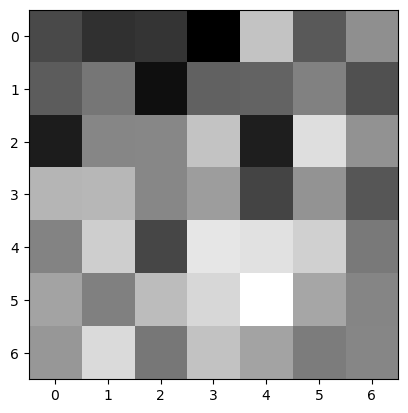

In [3]:
import matplotlib.pyplot as plt
plt.imshow(generated_image[0,:,:,0],cmap='gray')

In [4]:
from tensorflow.keras.models import Model
def discrimatior_model():
    model =tf.keras.Sequential()
    model.add(layers.Conv2D(64,(5,5),strides=(2,2),padding='same',input_shape=[7,7,1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.2))
    
    model.add(layers.Conv2D(128,(5,5),strides=(2,2),padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.2))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(1))
    return model

In [5]:
discrimator=discrimatior_model()
print(discrimator(generated_image))

tf.Tensor([[-0.01357104]], shape=(1, 1), dtype=float32)
